In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
sns.set(style='ticks', context='paper')

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'

In [6]:
cancer = pd.read_csv(url, header=None)
cancer.rename(columns={0:'id', 10:'class'}, inplace=True)

In [7]:
attributes = {1:'clump_thickness', 2:'cellsize_uniformity', 3:'cellshape_uniformity'
             , 4:'marginal_adhesion', 5:'single_epithelial_cellsize', 6:'bare_nuclei'
             , 7:'bland_chromatin', 8:'normal_nucleoli', 9:'mitoses'}

In [8]:
cancer.head()

,id,1,2,3,4,5,6,7,8,9,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
cancer[]

In [9]:
# converting 'class' label from (2,4) to (0,1)
cancer['class'] = cancer['class'].apply(lambda x: 0 if x==2 else 1)

In [10]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id       699 non-null int64
1        699 non-null int64
2        699 non-null int64
3        699 non-null int64
4        699 non-null int64
5        699 non-null int64
6        699 non-null object
7        699 non-null int64
8        699 non-null int64
9        699 non-null int64
class    699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [11]:
np.unique(cancer[6])

array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?'],
      dtype=object)

***
Column 6 contains value '?' in several columns.
- convert to 0 for EDA
- impute for model
    - check decisiontree.feature\_importances_ if column can be ignored

In [12]:
cancer[6] = cancer[6].apply(lambda x: 0 if x=='?' else x)
cancer[6] = cancer[6].astype('int64')

In [13]:
# create feature/target set before EDA
X0 = cancer.iloc[:, :-1]
y0 = cancer.iloc[:, -1:]

In [14]:
# converting df to sns-friendly format
cancer_sns = cancer.iloc[:, 1:].unstack().reset_index()
cancer_sns.columns = ['att', 'inst', 'val']

cancer_feat = cancer_sns.iloc[:6291] # the attributes

# the target; stack to itself 9 times (9 features) and attach to cancer_feat
cancer_targ = cancer_sns.iloc[6291:].rename(columns={'val':'class'}) 
cancer_targ.drop('att', 1, inplace=True)

cancer_class = cancer_feat.merge(cancer_targ, how='left', left_on='inst', right_on='inst')

In [15]:
# g = sns.FacetGrid(cancer_class, col="att", sharey=False, sharex=False, col_wrap=3)
# g.map(sns.distplot, 'val')
# plt.show()

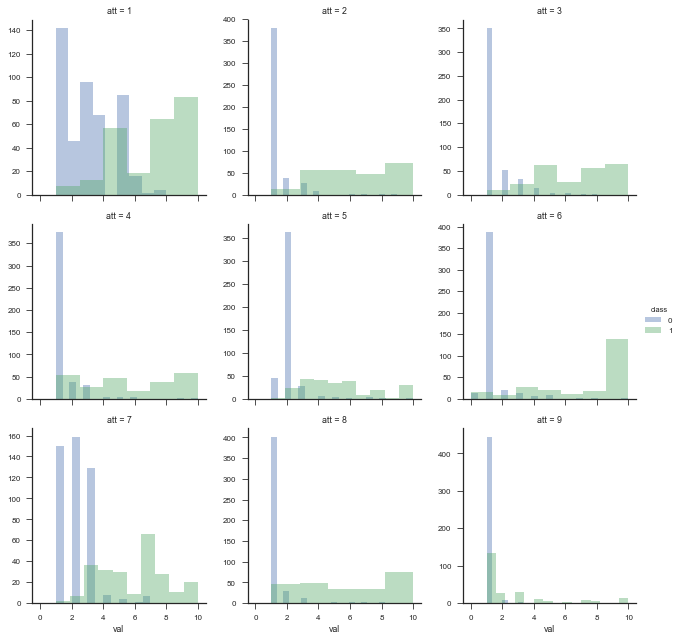

In [16]:
g = sns.FacetGrid(cancer_class, col="att", hue='class', sharey=False, sharex=True, col_wrap=3)
g.map(sns.distplot, 'val', kde=False).add_legend()
plt.show()

- Attributes 1 and 7 have more diverse ranges for benign instances than the other attributes. 
- Malignant instances tend to have either a uniform or a negatively-skewed distribution of scores
***

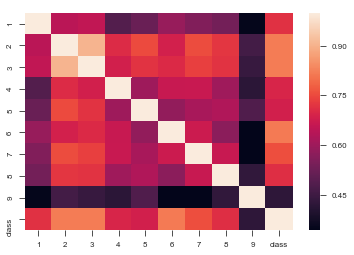

In [17]:
sns.heatmap(cancer.iloc[:, 1:].corr())

- all features have at least some correlation with the target class
- a lot of correlation among features; pca

C:\Users\Ryan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


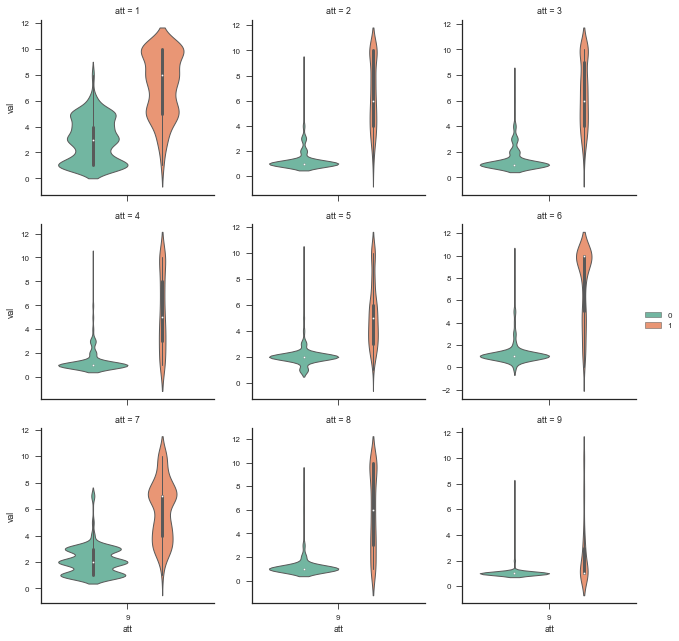

In [18]:
g = sns.FacetGrid(cancer_class, col="att", sharey=False, sharex=True, col_wrap=3)
g.map(sns.violinplot, 'att', 'val', 'class', hue_order=[0,1], 
          linewidth=1, size=10, palette='Set2', alpha=0.2).add_legend()
plt.show()

***
- train/test without missing values first, then impute 
- use gridsearch with a few models
    - will not be doing logistic for time being, and svc will be further down

In [19]:
X_1 = X0[X0[6]!=0] # instances with NO missing values
X_missing = X0[X0[6]==0] # instances with missing values

y_1 = y0.iloc[X_1.index]
y_missing = y0.iloc[X_missing.index]

- DecisionTree / RandomForest \.feature_importances_
- MultinomialNB \.coef_ 
    - and maybe feature_log_prob_, and class_log_prior_ with intercept_
- KNN
    - look into ball tree, kdtree;


In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

In [21]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X_1, y_1, random_state=42, test_size=0.2)

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC

In [24]:
mnb = MultinomialNB() # use for nlp

knn = KNeighborsClassifier(algorithm='kd_tree') # kd_tree
dt = DecisionTreeClassifier(random_state=42) 
et = ExtraTreesClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

lr = LogisticRegressionCV(random_state=42) # built in grid-search method

svc = SVC()

In [25]:
param_mnb = {'alpha': [i/10 for i in range(1, 11)]}
param_knn = {'n_neighbors': [i for i in range(1, 16)]}

param_dt = {'max_depth': [i+1 for i in range(10)]}
param_rf = {'max_depth': [i+1 for i in range(10)], 'n_estimators': [5,10,15,20,25,30]}
param_et = {'max_depth': [i+1 for i in range(10)], 'n_estimators': [5,10,15,20,25,30]}

Cs_log = [10**i for i in range(-4,4)]

In [26]:
scoring_metric = ['accuracy', 'recall', 'f1']

In [27]:
meancv_metric = ['mean_test_accuracy', 'std_test_accuracy',
                 'mean_test_recall', 'std_test_recall',
                 'mean_test_f1', 'std_test_f1']

In [28]:
def grid_search_cv(estimator=None, param_grid=None, scoring=scoring_metric,
                   cv=3, refit='recall', return_train_score=False, show_cv=False,
                   X1_train=X1_train, X1_val=X1_val, 
                   y1_train=y1_train, y1_val=y1_val):
    
    gs = GridSearchCV(estimator=estimator,
                     param_grid=param_grid,
                     scoring=scoring,
                     cv=cv,
                     refit=refit,
                     return_train_score=return_train_score)
    
    # best_params_ with resulting metric used for refit 
    gs = gs.fit(X1_train.iloc[:, 1:], y1_train['class'].ravel())
    print('The optimal paramters are ', gs.best_params_, 
           '\n with a training %s of %0.4f'% (refit, gs.best_score_))

    # cv mean and std
    cv_results = [gs.cv_results_[metric] for metric in meancv_metric]
    cv_mean_std = dict(zip(meancv_metric, cv_results));
    if show_cv == True:
        for k,v in cv_mean_std.items():
            print(k, '\n', v, '\n')
    
    clf = gs.best_estimator_
    clf.fit(X1_train.iloc[:, 1:], y1_train['class'].ravel())
    y1_ = clf.predict(X1_val.iloc[:, 1:])
    print('\nTest results')
    print (confusion_matrix(y1_val['class'].ravel(), y1_), 
           '\nAccuracy: %0.4f' % clf.score(X1_val.iloc[:, 1:], y1_val['class'].ravel()))
    return clf

In [29]:
clf_dt = grid_search_cv(dt, param_dt)

The optimal paramters are  {'max_depth': 2} 
 with a training recall of 0.9447

Test results
[[76  3]
 [ 7 51]] 
Accuracy: 0.9270


In [30]:
clf_rf = grid_search_cv(rf, param_rf)

The optimal paramters are  {'max_depth': 2, 'n_estimators': 5} 
 with a training recall of 0.9668

Test results
[[77  2]
 [ 4 54]] 
Accuracy: 0.9562


In [31]:
clf_et = grid_search_cv(et, param_et)

The optimal paramters are  {'max_depth': 4, 'n_estimators': 5} 
 with a training recall of 0.9614

Test results
[[77  2]
 [ 7 51]] 
Accuracy: 0.9343


In [32]:
clf_knn = grid_search_cv(knn, param_knn)

The optimal paramters are  {'n_neighbors': 3} 
 with a training recall of 0.9559

Test results
[[78  1]
 [ 6 52]] 
Accuracy: 0.9489


In [33]:
# disregard, problem child
clf_mnb = grid_search_cv(mnb, param_mnb)

The optimal paramters are  {'alpha': 0.1} 
 with a training recall of 0.7956

Test results
[[77  2]
 [14 44]] 
Accuracy: 0.8832


In [34]:
# feature_importances for dt and rf

In [35]:
clf_dt.feature_importances_

array([0.        , 0.8932024 , 0.00877125, 0.        , 0.        ,
       0.09802635, 0.        , 0.        , 0.        ])

In [36]:
clf_rf.feature_importances_

array([1.88504433e-02, 3.79157518e-01, 2.65768363e-01, 2.31688545e-04,
       0.00000000e+00, 1.68584548e-02, 3.19133533e-01, 0.00000000e+00,
       0.00000000e+00])

In [37]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

Text(0,0.5,'explained_variance_')

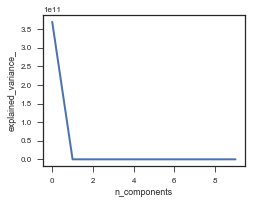

In [38]:
pca = PCA()
min_max = MinMaxScaler()
pipe_mnb = Pipeline([('pca', pca),
                     ('scale', min_max),
                ('mnb', mnb)])

pca.fit(X1_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [39]:
pca_components = [1,2,3,4,5]

In [40]:
estimator = GridSearchCV(estimator=pipe_mnb,
                        param_grid=dict(pca__n_components=pca_components,
                                        mnb__alpha=[i/10 for i in range(1, 11)]),
                        scoring='recall',
                        cv=3,
                        refit='recall',
                        return_train_score=False)

In [41]:
estimator.fit(X1_train, y1_train['class'].ravel())

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [1, 2, 3, 4, 5], 'mnb__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score=False,
       scoring='recall', verbose=0)

In [42]:
# clearly pca.n_components will be the biggest number
estimator.best_estimator_.named_steps['pca'].n_components

4

In [43]:
estimator.best_estimator_.named_steps['mnb'].alpha

0.1

In [44]:
best_est = estimator.best_estimator_

best_est.fit(X1_train,y1_train['class'].ravel())
ypca_ = best_est.predict(X1_val)
confusion_matrix(y1_val['class'].ravel(), ypca_)

# evidently, mnb not great for this case (mnb on original featureset not great)
## and apparently, neither with pca

array([[79,  0],
       [40, 18]], dtype=int64)

In [45]:
# imputing

In [46]:
imputer = Imputer(missing_values=0, strategy='median', axis=1)

In [47]:
X_impute_median = pd.DataFrame(imputer.fit_transform(X0))
X_impute_median[0] = X_impute_median[0].astype(int)
X_impute_median = X_impute_median.rename(columns={0:'id'})

In [48]:
X_nan_impute = X_impute_median.iloc[X_missing.index, :]

y_nan_impute = y_missing.copy()

- Even though the imputed sample is small, 
    - test on imputed sample, 
    - imputed sample as part of test/val, 
    - and imputed sample as part of the bigger train

In [49]:
# best accuracy and recall was rf
clf_rf_imp = grid_search_cv(estimator=rf, param_grid=param_rf, X1_val=X_nan_impute,
                       y1_val=y_nan_impute)

The optimal paramters are  {'max_depth': 2, 'n_estimators': 5} 
 with a training recall of 0.9668

Test results
[[12  2]
 [ 0  2]] 
Accuracy: 0.8750


- of course, the test sample size is not ideal, but the model still correctly identified the positive labels
- attach imputed samples to test/val set, then training set

In [50]:
X2_val = pd.concat([X1_val, X_nan_impute])
y2_val = pd.concat([y1_val, y_nan_impute])

In [51]:
clf_rf_imp_val = grid_search_cv(estimator=rf, param_grid=param_rf, X1_val=X2_val,
                       y1_val=y2_val)

The optimal paramters are  {'max_depth': 2, 'n_estimators': 5} 
 with a training recall of 0.9668

Test results
[[89  4]
 [ 4 56]] 
Accuracy: 0.9477


    - learned something today.....

In [52]:
X2_train = pd.concat([X1_train, X_nan_impute])
y2_train = pd.concat([y1_train, y_nan_impute])

In [53]:
clf_rf_imp_train = grid_search_cv(estimator=rf, param_grid=param_rf, X1_train=X2_train,
                       y1_train=y2_train)

The optimal paramters are  {'max_depth': 2, 'n_estimators': 5} 
 with a training recall of 0.9727

Test results
[[77  2]
 [ 4 54]] 
Accuracy: 0.9562


-resample with imputed sample

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_impute_median, y0, test_size=.2)

In [62]:
clf_rf_imp = grid_search_cv(estimator=rf, param_grid=param_rf, X1_train=X_train,
                                 X1_val=X_test, y1_train=y_train, y1_val=y_test)

The optimal paramters are  {'max_depth': 2, 'n_estimators': 10} 
 with a training recall of 0.9706

Test results
[[98  5]
 [ 0 37]] 
Accuracy: 0.9643


In [63]:
clf_dt = grid_search_cv(dt, param_dt, X1_train=X_train,
                                 X1_val=X_test, y1_train=y_train, y1_val=y_test)

The optimal paramters are  {'max_depth': 7} 
 with a training recall of 0.9216

Test results
[[99  4]
 [ 4 33]] 
Accuracy: 0.9429


In [64]:
clf_knn = grid_search_cv(knn, param_knn, X1_train=X_train,
                                 X1_val=X_test, y1_train=y_train, y1_val=y_test)

The optimal paramters are  {'n_neighbors': 3} 
 with a training recall of 0.9608

Test results
[[101   2]
 [  2  35]] 
Accuracy: 0.9714


In [65]:
clf_et = grid_search_cv(et, param_et, X1_train=X_train,
                                 X1_val=X_test, y1_train=y_train, y1_val=y_test)

The optimal paramters are  {'max_depth': 8, 'n_estimators': 30} 
 with a training recall of 0.9804

Test results
[[101   2]
 [  2  35]] 
Accuracy: 0.9714


Citation Request:
   This breast cancer databases was obtained from the University of Wisconsin
   Hospitals, Madison from Dr. William H. Wolberg.  If you publish results
   when using this database, then please include this information in your
   acknowledgements.  Also, please cite one or more of:

   1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

   2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology", 
      Proceedings of the National Academy of Sciences, U.S.A., Volume 87, 
      December 1990, pp 9193-9196.

   3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition 
      via linear programming: Theory and application to medical diagnosis", 
      in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying
      Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.

   4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming 
      discrimination of two linearly inseparable sets", Optimization Methods
      and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

1. Title: Wisconsin Breast Cancer Database (January 8, 1991)

2. Sources:
   -- Dr. WIlliam H. Wolberg (physician)
      University of Wisconsin Hospitals
      Madison, Wisconsin
      USA
   -- Donor: Olvi Mangasarian (mangasarian@cs.wisc.edu)
      Received by David W. Aha (aha@cs.jhu.edu)
   -- Date: 15 July 1992

3. Past Usage:

   Attributes 2 through 10 have been used to represent instances.
   Each instance has one of 2 possible classes: benign or malignant.

   1. Wolberg,~W.~H., \& Mangasarian,~O.~L. (1990). Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology. In
      {\it Proceedings of the National Academy of Sciences}, {\it 87},
      9193--9196.
      -- Size of data set: only 369 instances (at that point in time)
      -- Collected classification results: 1 trial only
      -- Two pairs of parallel hyperplanes were found to be consistent with
         50% of the data
         -- Accuracy on remaining 50% of dataset: 93.5%
      -- Three pairs of parallel hyperplanes were found to be consistent with
         67% of data
         -- Accuracy on remaining 33% of dataset: 95.9%

   2. Zhang,~J. (1992). Selecting typical instances in instance-based
      learning.  In {\it Proceedings of the Ninth International Machine
      Learning Conference} (pp. 470--479).  Aberdeen, Scotland: Morgan
      Kaufmann.
      -- Size of data set: only 369 instances (at that point in time)
      -- Applied 4 instance-based learning algorithms 
      -- Collected classification results averaged over 10 trials
      -- Best accuracy result: 
         -- 1-nearest neighbor: 93.7%
         -- trained on 200 instances, tested on the other 169
      -- Also of interest:
         -- Using only typical instances: 92.2% (storing only 23.1 instances)
         -- trained on 200 instances, tested on the other 169

4. Relevant Information:

   Samples arrive periodically as Dr. Wolberg reports his clinical cases.
   The database therefore reflects this chronological grouping of the data.
   This grouping information appears immediately below, having been removed
   from the data itself:

     Group 1: 367 instances (January 1989)
     Group 2:  70 instances (October 1989)
     Group 3:  31 instances (February 1990)
     Group 4:  17 instances (April 1990)
     Group 5:  48 instances (August 1990)
     Group 6:  49 instances (Updated January 1991)
     Group 7:  31 instances (June 1991)
     Group 8:  86 instances (November 1991)
     -----------------------------------------
     Total:   699 points (as of the donated datbase on 15 July 1992)

   Note that the results summarized above in Past Usage refer to a dataset
   of size 369, while Group 1 has only 367 instances.  This is because it
   originally contained 369 instances; 2 were removed.  The following
   statements summarizes changes to the original Group 1's set of data:

   #####  Group 1 : 367 points: 200B 167M (January 1989)
   #####  Revised Jan 10, 1991: Replaced zero bare nuclei in 1080185 & 1187805
   #####  Revised Nov 22,1991: Removed 765878,4,5,9,7,10,10,10,3,8,1 no record
   #####                  : Removed 484201,2,7,8,8,4,3,10,3,4,1 zero epithelial
   #####                  : Changed 0 to 1 in field 6 of sample 1219406
   #####                  : Changed 0 to 1 in field 8 of following sample:
   #####                  : 1182404,2,3,1,1,1,2,0,1,1,1

5. Number of Instances: 699 (as of 15 July 1992)

6. Number of Attributes: 10 plus the class attribute

7. Attribute Information: (class attribute has been moved to last column)

   #  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)

8. Missing attribute values: 16

   There are 16 instances in Groups 1 to 6 that contain a single missing 
   (i.e., unavailable) attribute value, now denoted by "?".  

9. Class distribution:
 
   Benign: 458 (65.5%)
   Malignant: 241 (34.5%)

In [55]:
# sp_expon(scale=100)
# randomized search vs gridsearch

In [56]:
# for RandomizedSearchCV
# for distribution, higher prob of selecting certain numbers
from scipy.stats import expon as sp_expon
from scipy.stats import randint as sp_randint

In [57]:
pca on svc; takes too long

SyntaxError: invalid syntax (<ipython-input-57-9b584faba2e8>, line 1)

- plot decision function

In [ ]:
param_svc = [10**i for i in range(-4,4)]

svc = SVC(random_state=42)
pca_svc = PCA()
pipe_svc = Pipeline([('pca', pca),
                     ('svc', svc)])

In [ ]:
param_range = [10**i for i in range(-4,4)]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
             {'svc__C': param_range,
             'svc__gamma': param_range,
             'svc__kernel':['rbf']}]

In [ ]:
gs_svc = GridSearchCV(estimator=pipe_svc,
                     param_grid=param_grid,
                     scoring='recall',
                     cv=3,
                     return_train_score=False)

In [ ]:
gs_svc = gs_svc.fit(X1_train, y1_train['class'].ravel())

In [ ]:
gs_svc.best_score_

In [ ]:
gs_svc.best_params_

In [ ]:
clf_svc = gs_svc.best_params_

In [ ]:
clf_svc.fit(X1_train,y1_train['class'].ravel())

In [ ]:
clf.score(X1_val, y1_val)